In [39]:
sys.path.append('/home/shinzato/GitHub/power-law-research/power_law_research')
from datetime import datetime
import pytorch_lightning  as pl

from models import LitVanillaVAE
from data_modules import FashionMNISTDataModule



logger = pl.loggers.TensorBoardLogger(save_dir=f"../log/vanilla_{str(datetime.now())}")
model = LitVanillaVAE(n_vis=784, n_hid=100, optimizer_name="sgd")
data_module = FashionMNISTDataModule(batch_size=128)
trainer = pl.Trainer(max_epochs=10, devices=1, accelerator="gpu", logger=logger)
trainer.fit(model, data_module)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ../log/vanilla_2022-07-11 17:58:46.689994/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name         | Type       | Params
--------------------------------------------
0 | encoder_mean | Sequential | 78.5 K
1 | encoder_var  | Sequential | 78.5 K
2 | decoder      | Sequential | 79.2 K
--------------------------------------------
236 K     Trainable params
0         Non-trainable params
236 K     Total params
0.945     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [40]:
import numpy as np
from utils import sample_neuron_firings, pca_variance

firings = sample_neuron_firings(model, data_module.train_dataloader())
pc_dim, pc_var = pca_variance(firings)
log_pc_dim, log_var = np.log(pc_dim), np.log(pc_var)

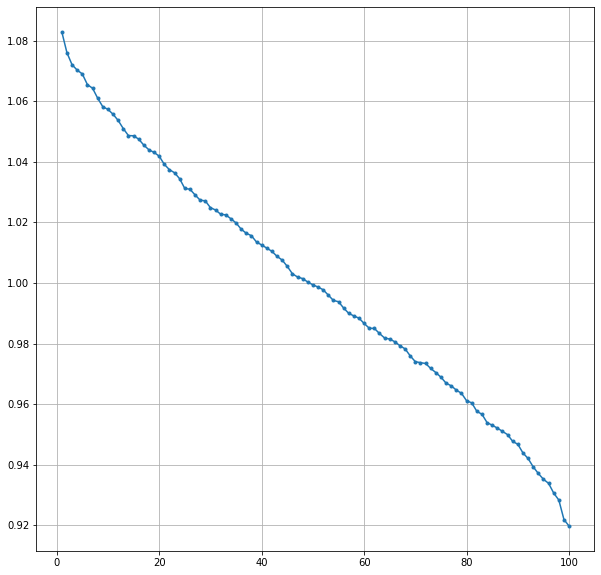

In [41]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
ax.grid()
# ax.set_xscale("log")
# ax.set_yscale("log")
ax.plot(pc_dim, pc_var, ".-")

In [42]:
from models import LitScaleFreeVAE

model = LitScaleFreeVAE(n_vis=784, power_law_gamma=1)
logger = pl.loggers.TensorBoardLogger(save_dir=f"../log/scale_free{str(datetime.now())}")
data_module = FashionMNISTDataModule(batch_size=128)
trainer = pl.Trainer(max_epochs=10, devices=1, accelerator="gpu", logger=logger)
trainer.fit(model, data_module)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ../log/scale_free2022-07-11 17:59:32.726085/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name         | Type       | Params
--------------------------------------------
0 | encoder_mean | Sequential | 78.5 K
1 | encoder_var  | Sequential | 78.5 K
2 | decoder      | Sequential | 79.2 K
--------------------------------------------
236 K     Trainable params
0         Non-trainable params
236 K     Total params
0.945     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

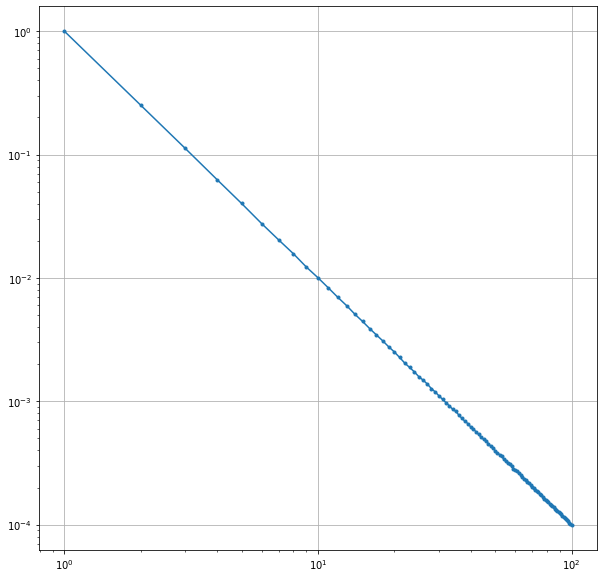

In [43]:
import numpy as np
from utils import sample_neuron_firings, pca_variance
import matplotlib.pyplot as plt

firings = sample_neuron_firings(model, data_module.train_dataloader())
pc_dim, pc_var = pca_variance(firings)
log_pc_dim, log_var = np.log(pc_dim), np.log(pc_var)

fig, ax = plt.subplots(figsize=(10, 10))
ax.grid()
ax.set_xscale("log")
ax.set_yscale("log")
ax.plot(pc_dim, pc_var, ".-")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ../log/vary_gamma/2022-07-11 18:00:42.991397_scalefree_gamma_0.0/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name         | Type       | Params
--------------------------------------------
0 | encoder_mean | Sequential | 78.5 K
1 | encoder_var  | Sequential | 78.5 K
2 | decoder      | Sequential | 79.2 K
--------------------------------------------
236 K     Trainable params
0         Non-trainable params
236 K     Total params
0.945     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ../log/vary_gamma/2022-07-11 18:01:46.713526_scalefree_gamma_0.1/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name         | Type       | Params
--------------------------------------------
0 | encoder_mean | Sequential | 78.5 K
1 | encoder_var  | Sequential | 78.5 K
2 | decoder      | Sequential | 79.2 K
--------------------------------------------
236 K     Trainable params
0         Non-trainable params
236 K     Total params
0.945     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ../log/vary_gamma/2022-07-11 18:02:54.665954_scalefree_gamma_0.2/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name         | Type       | Params
--------------------------------------------
0 | encoder_mean | Sequential | 78.5 K
1 | encoder_var  | Sequential | 78.5 K
2 | decoder      | Sequential | 79.2 K
--------------------------------------------
236 K     Trainable params
0         Non-trainable params
236 K     Total params
0.945     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ../log/vary_gamma/2022-07-11 18:04:01.708460_scalefree_gamma_0.3/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name         | Type       | Params
--------------------------------------------
0 | encoder_mean | Sequential | 78.5 K
1 | encoder_var  | Sequential | 78.5 K
2 | decoder      | Sequential | 79.2 K
--------------------------------------------
236 K     Trainable params
0         Non-trainable params
236 K     Total params
0.945     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ../log/vary_gamma/2022-07-11 18:05:09.997939_scalefree_gamma_0.4/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name         | Type       | Params
--------------------------------------------
0 | encoder_mean | Sequential | 78.5 K
1 | encoder_var  | Sequential | 78.5 K
2 | decoder      | Sequential | 79.2 K
--------------------------------------------
236 K     Trainable params
0         Non-trainable params
236 K     Total params
0.945     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ../log/vary_gamma/2022-07-11 18:06:18.790017_scalefree_gamma_0.5/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name         | Type       | Params
--------------------------------------------
0 | encoder_mean | Sequential | 78.5 K
1 | encoder_var  | Sequential | 78.5 K
2 | decoder      | Sequential | 79.2 K
--------------------------------------------
236 K     Trainable params
0         Non-trainable params
236 K     Total params
0.945     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ../log/vary_gamma/2022-07-11 18:07:25.819206_scalefree_gamma_0.6/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name         | Type       | Params
--------------------------------------------
0 | encoder_mean | Sequential | 78.5 K
1 | encoder_var  | Sequential | 78.5 K
2 | decoder      | Sequential | 79.2 K
--------------------------------------------
236 K     Trainable params
0         Non-trainable params
236 K     Total params
0.945     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ../log/vary_gamma/2022-07-11 18:08:33.982575_scalefree_gamma_0.7/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name         | Type       | Params
--------------------------------------------
0 | encoder_mean | Sequential | 78.5 K
1 | encoder_var  | Sequential | 78.5 K
2 | decoder      | Sequential | 79.2 K
--------------------------------------------
236 K     Trainable params
0         Non-trainable params
236 K     Total params
0.945     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ../log/vary_gamma/2022-07-11 18:09:42.590401_scalefree_gamma_0.8/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name         | Type       | Params
--------------------------------------------
0 | encoder_mean | Sequential | 78.5 K
1 | encoder_var  | Sequential | 78.5 K
2 | decoder      | Sequential | 79.2 K
--------------------------------------------
236 K     Trainable params
0         Non-trainable params
236 K     Total params
0.945     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ../log/vary_gamma/2022-07-11 18:10:52.155258_scalefree_gamma_0.9/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name         | Type       | Params
--------------------------------------------
0 | encoder_mean | Sequential | 78.5 K
1 | encoder_var  | Sequential | 78.5 K
2 | decoder      | Sequential | 79.2 K
--------------------------------------------
236 K     Trainable params
0         Non-trainable params
236 K     Total params
0.945     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ../log/vary_gamma/2022-07-11 18:12:00.041045_scalefree_gamma_1.0/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name         | Type       | Params
--------------------------------------------
0 | encoder_mean | Sequential | 78.5 K
1 | encoder_var  | Sequential | 78.5 K
2 | decoder      | Sequential | 79.2 K
--------------------------------------------
236 K     Trainable params
0         Non-trainable params
236 K     Total params
0.945     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ../log/vary_gamma/2022-07-11 18:13:08.735992_scalefree_gamma_1.1/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name         | Type       | Params
--------------------------------------------
0 | encoder_mean | Sequential | 78.5 K
1 | encoder_var  | Sequential | 78.5 K
2 | decoder      | Sequential | 79.2 K
--------------------------------------------
236 K     Trainable params
0         Non-trainable params
236 K     Total params
0.945     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ../log/vary_gamma/2022-07-11 18:14:17.674436_scalefree_gamma_1.2/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name         | Type       | Params
--------------------------------------------
0 | encoder_mean | Sequential | 78.5 K
1 | encoder_var  | Sequential | 78.5 K
2 | decoder      | Sequential | 79.2 K
--------------------------------------------
236 K     Trainable params
0         Non-trainable params
236 K     Total params
0.945     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ../log/vary_gamma/2022-07-11 18:15:26.021957_scalefree_gamma_1.3/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name         | Type       | Params
--------------------------------------------
0 | encoder_mean | Sequential | 78.5 K
1 | encoder_var  | Sequential | 78.5 K
2 | decoder      | Sequential | 79.2 K
--------------------------------------------
236 K     Trainable params
0         Non-trainable params
236 K     Total params
0.945     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ../log/vary_gamma/2022-07-11 18:16:34.793928_scalefree_gamma_1.4/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name         | Type       | Params
--------------------------------------------
0 | encoder_mean | Sequential | 78.5 K
1 | encoder_var  | Sequential | 78.5 K
2 | decoder      | Sequential | 79.2 K
--------------------------------------------
236 K     Trainable params
0         Non-trainable params
236 K     Total params
0.945     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

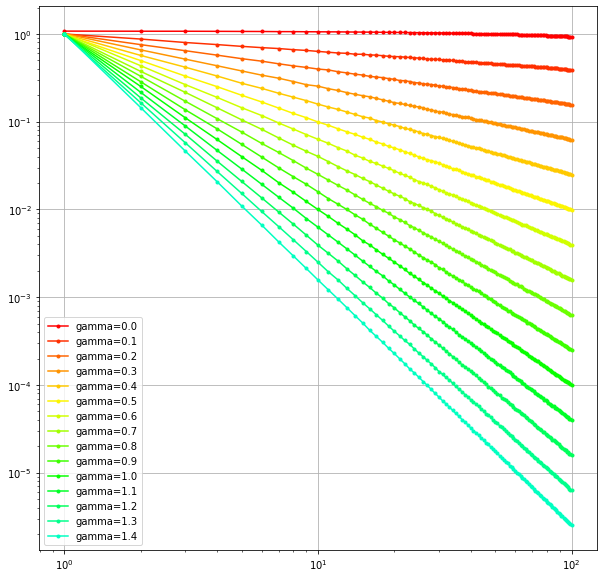

In [44]:
import matplotlib.cm as cm
fig, ax = plt.subplots(figsize=(10, 10))
ax.grid()
ax.set_xscale("log")
ax.set_yscale("log")

for i, gamma in enumerate([0.1 * i for i in range(15)]):
    model = LitScaleFreeVAE(n_vis=784, power_law_gamma=gamma)
    logger = pl.loggers.TensorBoardLogger(save_dir=f"../log/vary_gamma/{str(datetime.now())}_scalefree_gamma_{gamma:.2}")
    data_module = FashionMNISTDataModule(batch_size=128)
    trainer = pl.Trainer(max_epochs=10, devices=1, accelerator="gpu", logger=logger)
    trainer.fit(model, data_module)

    firings = sample_neuron_firings(model, data_module.train_dataloader())
    pc_dim, pc_var = pca_variance(firings)
    ax.plot(pc_dim, pc_var, ".-", label=f"gamma={gamma:.2}", color=cm.hsv(i/30.0))
    ax.legend()


![logs](./%E3%82%B9%E3%82%AF%E3%83%AA%E3%83%BC%E3%83%B3%E3%82%B7%E3%83%A7%E3%83%83%E3%83%88%202022-07-11%2018.26.56.png)